# Modern Robot Learning — Lecture 1 · Part 3  
## Differential Inverse Kinematics (Jacobian Pseudo-Inverse) & Trajectory Tracking

**Goal:**  
Understand how small joint-space changes produce Cartesian-space motions and how to use the *Jacobian pseudo-inverse* to follow a desired end-effector trajectory.

---

### 🌱 Concepts Covered
- Relationship between **joint velocities** and **end-effector velocities**  
  \[
  \dot p = J(q)\,\dot q
  \]
- **Jacobian pseudo-inverse** and **damped least squares**:
  \[
  \dot q = J^+(q)\,\dot p^*
  \]
- **Discrete integration** of joint velocities  
  \[
  q_{t+1} = q_t + \Delta t\,\dot q_t
  \]
- Tracking **desired trajectories** (circle / line) in task space  
- Visualizing and understanding **singularities** and **damping**

---

### 🧩 Learning Objectives
By the end of this notebook, you will be able to:
1. Derive and compute the **Jacobian** for a 2-DOF planar arm.  
2. Implement **Differential IK** using the **Jacobian pseudo-inverse**.  
3. Apply **Damped Least Squares (DLS)** to handle singularities.  
4. Generate and follow simple **Cartesian trajectories**.  
5. Plot and compare **desired vs. executed** end-effector paths.

---

### 📚 References
- Lynch & Park (2017) — *Modern Robotics: Mechanics, Planning, and Control*  
- Siciliano & Khatib (2016) — *Springer Handbook of Robotics*  
- Tedrake — *Underactuated Robotics Course Notes*  


### Imports


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib inline  # Uncomment in Jupyter/Colab if needed


### Kinematics & Jacobian

In [ ]:
def fk(theta1, theta2, l1=1.0, l2=1.0):
    """Forward kinematics: q=[θ1, θ2] -> p=[px, py]."""
    px = l1*np.cos(theta1) + l2*np.cos(theta1 + theta2)
    py = l1*np.sin(theta1) + l2*np.sin(theta1 + theta2)
    return np.array([px, py])

def jacobian(theta1, theta2, l1=1.0, l2=1.0):
    """Geometric Jacobian J = ∂p/∂q for the 2-link planar arm (2x2)."""
    s1, c1 = np.sin(theta1), np.cos(theta1)
    s12, c12 = np.sin(theta1+theta2), np.cos(theta1+theta2)
    J = np.array([[-l1*s1 - l2*s12, -l2*s12],
                  [ l1*c1 + l2*c12,  l2*c12]])
    return J


##Pseudo-inverse

In [ ]:
def pinv(J, lam=0.0):
    """
    Compute Moore–Penrose pseudo-inverse.
    If lam > 0, it becomes the damped least-squares inverse.
    """
    JT = J.T
    return JT @ np.linalg.inv(J @ JT + (lam**2) * np.eye(J.shape[0]))


### Differential IK Tracking

In [ ]:
def differential_ik(q0, p_star_fn, T=6.0, dt=0.01, l1=1.0, l2=1.0, lam=1e-2):
    """
    Implements eq. (2):
        q_dot = J^+(q) * p_dot*(t)
        q_{t+1} = q_t + dt * q_dot
    """
    ts = np.arange(0, T, dt)
    q = np.array(q0, dtype=float)

    Q, P, P_des = [], [], []

    for t in ts:
        # Desired position and velocity in Cartesian space
        p_star, p_dot_star = p_star_fn(t)

        # Compute Jacobian and its pseudo-inverse
        J = jacobian(q[0], q[1], l1, l2)
        J_pinv = pinv(J, lam)

        # Solve for joint velocities
        q_dot = J_pinv @ p_dot_star

        # Integrate over time to get new configuration
        q = q + dt * q_dot

        # Store results
        Q.append(q.copy())
        P.append(fk(q[0], q[1], l1, l2))
        P_des.append(p_star.copy())

    return np.array(ts), np.array(Q), np.array(P), np.array(P_des)


### Define desired trajectory

In [ ]:
def circular_trajectory(cx=1.0, cy=0.5, r=0.2, T=5.0):
    """
    Defines a circular trajectory in task space with its velocity.
    p*(t) = [cx + r cos(ωt), cy + r sin(ωt)]
    p_dot*(t) = [-rω sin(ωt), rω cos(ωt)]
    """
    ω = 2 * np.pi / T
    def traj(t):
        p = np.array([cx + r * np.cos(ω*t), cy + r * np.sin(ω*t)])
        p_dot = np.array([-r * ω * np.sin(ω*t), r * ω * np.cos(ω*t)])
        return p, p_dot
    return traj


In [ ]:
def ellipse_traj(cx=1.0, cy=0.6, a=0.3, b=0.15, T=6.0):
    ω = 2*np.pi / T
    def traj(t):
        p = np.array([cx + a*np.cos(ω*t), cy + b*np.sin(ω*t)])
        p_dot = np.array([-a*ω*np.sin(ω*t),  b*ω*np.cos(ω*t)])
        return p, p_dot
    return traj


In [ ]:
def spiral_traj(cx=1.0, cy=0.6, r0=0.25, decay=0.15, T=8.0):
    ω = 4*np.pi / T  # two turns
    def traj(t):
        r = r0 * np.exp(-decay * t)
        p = np.array([cx + r*np.cos(ω*t), cy + r*np.sin(ω*t)])
        p_dot = np.array([
            -r*ω*np.sin(ω*t) - decay*r*np.cos(ω*t),
             r*ω*np.cos(ω*t) - decay*r*np.sin(ω*t)
        ])
        return p, p_dot
    return traj


In [ ]:
def lissajous_traj(cx=1.0, cy=0.6, ax=0.25, ay=0.15, fx=1.0, fy=2.0, T=6.0):
    ωx = 2*np.pi*fx / T
    ωy = 2*np.pi*fy / T
    def traj(t):
        p = np.array([cx + ax*np.sin(ωx*t), cy + ay*np.sin(ωy*t)])
        p_dot = np.array([ax*ωx*np.cos(ωx*t), ay*ωy*np.cos(ωy*t)])
        return p, p_dot
    return traj


### Run the differential IK example

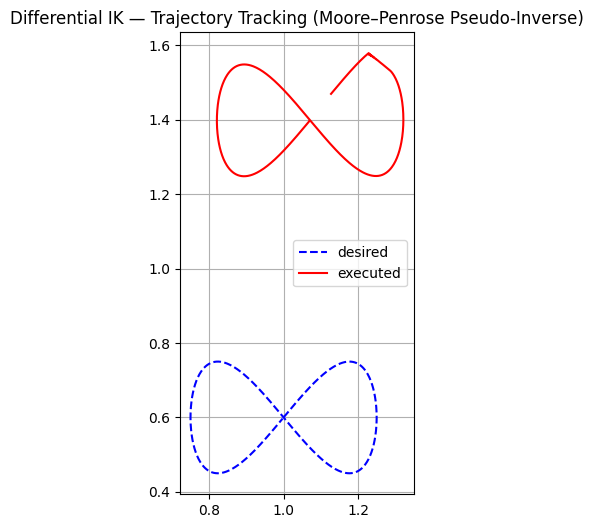

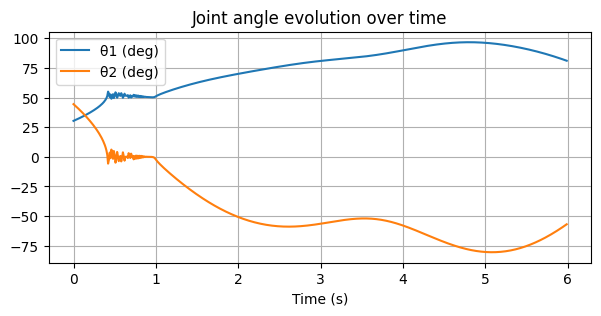

In [ ]:
# Robot parameters
l1 = l2 = 1.0
q0 = np.deg2rad([30.0, 45.0])  # starting joint configuration

# Desired trajectory
p_star_fn = lissajous_traj()

# Run diff-IK
ts, Q, P, P_des = differential_ik(q0, p_star_fn, T=6.0, dt=0.01, l1=l1, l2=l2, lam=1e-2)

# Plot results
plt.figure(figsize=(6,6))
plt.plot(P_des[:,0], P_des[:,1], 'b--', label="desired")
plt.plot(P[:,0], P[:,1], 'r-', label="executed")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.title("Differential IK — Trajectory Tracking (Moore–Penrose Pseudo-Inverse)")
plt.show()

plt.figure(figsize=(7,3))
plt.plot(ts, np.rad2deg(Q[:,0]), label='θ1 (deg)')
plt.plot(ts, np.rad2deg(Q[:,1]), label='θ2 (deg)')
plt.grid(True); plt.legend(); plt.xlabel("Time (s)")
plt.title("Joint angle evolution over time")
plt.show()
